# Star or Galaxy?

- [Schema Browser](https://skyserver.sdss.org/dr9/en/help/browser/browser.asp)
- SQL Query: 
```
SELECT pt.name, po.type, po.ra, po.dec, po.u, po.g, po.r, po.i, po.z
FROM PhotoObj po
JOIN PhotoType pt ON pt.value = po.type
```

 - [Flux magnitudes](https://voyages.sdss.org/preflight/light/filters/): u, g, r, i and z
    - total light/flux received
    - u’ – ultraviolet light
    - g’ – blue and green visible light
    - r’ – yellow and red visible light
    - i’ – near-infrared light
    - z’ – near-infrared light
columns: u-g, g-r, r-i, i-z
- We calculate redshift by measuring flux

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# import pydotplus
# from IPython.display import Image

In [2]:
## find median of train/test result data
def median_diff(predicted, actual):
  median = np.median(np.abs(predicted-actual))
  return median

# validate the model and print the med_diff
# diff = validate_model(dtr, features, targets)

## Data Cleaning

In [3]:
raw_data = pd.read_csv('star_classification.csv')

In [19]:
## dropping NaNs
data = raw_data[['u', 'g', 'r', 'i', 'z', 'class']]
data.dropna(how='any')
data.head()

,u,g,r,i,z,class
0,20.771816,18.526823,17.392050,16.887115,16.500648,GALAXY
1,20.190552,20.111183,20.003725,19.536736,19.366606,QSO
2,20.658936,19.767363,20.112465,19.771290,19.810503,GALAXY
3,22.210409,19.843256,18.377989,17.126400,16.440516,STAR
4,20.798119,19.537325,19.040367,18.827971,18.753901,STAR


In [15]:
# data classes
data['class'].value_counts().sort_values

<bound method Series.sort_values of class
GALAXY    20260
STAR      11024
QSO        3716
Name: count, dtype: int64>

In [18]:
fig = px.histogram(data, x="class").update_xaxes(categoryorder='total descending')
fig.update_layout(
    title_text = 'Counts of types of objects in dataset'
)
fig.show()
fig.write_html('img/sqg_counts.html')

In [6]:
# dummies for decision tree classifiers
dummies = pd.get_dummies(data["class"])
data = pd.concat([data, dummies], axis = 1)

## Decision trees training

In [8]:
# features and target train test split
features = data.copy().drop(columns=['class', 'GALAXY', 'QSO', 'STAR'])
target = data.copy()['class']

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size = 0.3)

# Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

# predictions
y_pred_dt = model_dt.predict(X_test)


### Metrics

In [9]:
# confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_df_dt = pd.DataFrame(cm_dt,
                     index = ['GALAXY', 'QSO', 'STAR'],
                     columns = ['GALAXY', 'QSO', 'STAR'])


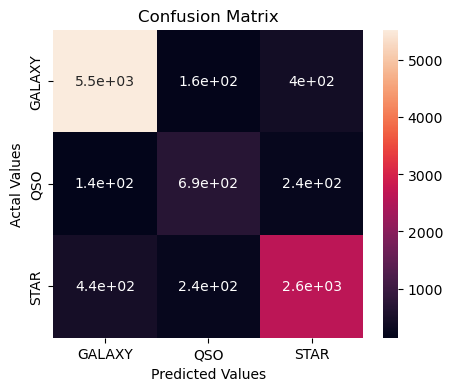

In [10]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_dt, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [11]:
# Accuracy score
accuracy_score(y_pred_dt, y_test.to_numpy())

0.8451428571428572

In [13]:
# Calculate metrics
accuracy_dt = accuracy_score(y_pred_dt, y_test.to_numpy())
cr = classification_report(y_pred_dt, y_test.to_numpy())

print("Accuracy:", accuracy_dt)
print ("Classification report: \n", cr)


Accuracy: 0.8451428571428572
Classification report: 
               precision    recall  f1-score   support

      GALAXY       0.91      0.91      0.91      6115
         QSO       0.65      0.63      0.64      1096
        STAR       0.79      0.80      0.80      3289

    accuracy                           0.85     10500
   macro avg       0.78      0.78      0.78     10500
weighted avg       0.85      0.85      0.85     10500



## Random forest

In [14]:
# features and target train test split
features = data.copy().drop(columns=['class', 'GALAXY', 'QSO', 'STAR'])
target = data.copy()['class']

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size = 0.3)

# Decision Tree model
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# predictions
y_pred_rf = model_rf.predict(X_test)


### Metrics

In [15]:
# confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_df_rf = pd.DataFrame(cm_rf,
                     index = ['GALAXY', 'QSO', 'STAR'],
                     columns = ['GALAXY', 'QSO', 'STAR'])


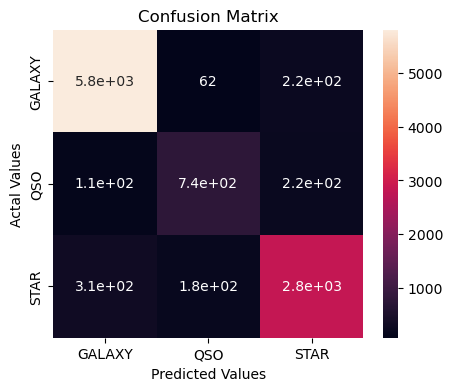

In [16]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_rf, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [17]:
# Accuracy score
accuracy_score(y_pred_rf, y_test.to_numpy())

0.8953333333333333

In [18]:
# Calculate metrics
accuracy_rf = accuracy_score(y_pred_rf, y_test.to_numpy())
cr_rf = classification_report(y_pred_rf, y_test.to_numpy())

print("Accuracy:", accuracy_rf)
print ("Classification report: \n", cr_rf)


Accuracy: 0.8953333333333333
Classification report: 
               precision    recall  f1-score   support

      GALAXY       0.95      0.93      0.94      6237
         QSO       0.69      0.76      0.72       983
        STAR       0.85      0.87      0.86      3280

    accuracy                           0.90     10500
   macro avg       0.83      0.85      0.84     10500
weighted avg       0.90      0.90      0.90     10500



## Visualizations

In [22]:
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=("Decision Tree Classification", "Random Forest Classification"))
fig.add_trace(px.imshow(cm_df_dt, text_auto=True).data[0], row=1, col=1)
fig.add_trace(px.imshow(cm_df_rf, text_auto=True).data[0], row=1, col=2)

fig.show()
fig.write_html('img/sog.html')